# Курсовой проект для курса "Python для Data Science"

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:
Price

#### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

#### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.


#### Описание датасета:
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split

In [37]:
TEST_DATASET_PATH = "test.csv"
TRAIN_DATASET_PATH = "train.csv"

In [38]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Уменьшаем объем данных

In [39]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

#### Разбиваем на тест и трейн

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop("Price", axis = 1), df["Price"], test_size=0.3, random_state=47)

In [42]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,7000.000000,7000.000000,7000.000000,7000.000000,5514.000000,7000.000000,7000.000000,7000.000000,7.000000e+03,7000.000000,7000.000000,7000.000000,7000.000000,3622.000000,7000.000000,7000.000000
mean,8355.944429,50.380286,1.890857,56.349125,36.334522,6.431143,8.465857,12.551143,4.849407e+03,0.118864,24.799000,5384.084286,8.007000,1164.085327,1.319286,4.228714
std,4859.364585,43.750859,0.850480,21.555962,20.853006,33.960041,5.200314,6.739928,2.396436e+05,0.118758,17.631259,4036.855151,23.562797,1037.780518,1.491194,4.780312
min,0.000000,0.000000,0.000000,1.988943,0.641822,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4179.750000,20.000000,1.000000,41.784348,22.726414,1.000000,4.000000,9.000000,1.973000e+03,0.019509,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8344.000000,35.000000,2.000000,52.413246,32.810188,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5288.000000,2.000000,990.000000,1.000000,3.000000
75%,12541.750000,75.000000,2.000000,65.981638,45.099518,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.000000,209.000000,19.000000,641.065186,638.163208,2014.000000,33.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


##### Для начала надо "причесать" имеющиеся не НаН значения, далее нужно избавиться от НаН значений.
- Id можно исключить из анализа, т.к. он не несет полезной информации, только индекс. Или использовать вместо индекса строк.
- District минимальный 0, врядли это верное значение, т.к. это скорее категориальное значение можно заменить модой
- Rooms 0 врядли верное значение, даже студия считается минимум 1 комнатой. Можно высчитать среднюю площадь на комнату из имеющихся данных и вставлять в 0 значения Lifesquare / среднее площадь и округлить до целого. Также стоит проверить максимальное значеие комнат. При 0.75 квантиле == 2, скорее всего это выброс.  
- Square минимальная и максимальная площадь подозрительны
- LifeSquare  также минимальная и максимальное значение подозрительны, вообще максимальная жилая площадь не может быть выше общей.
- KitchenSquare таже история с максимальным и минимальным. 
- Floor вроде все ок, разве что проверить максимальное значение..
- HouseFloor 0 этажей не может быть. 
- HouseYear посмотреть колонку отдельно
- Ecology_1	Social_1	Social_2	Social_3	Healthcare_1	Helthcare_2	Shops_1 не понятно, что за показатели, так что нужно посмотреть выбросы при помощи правила 3сигм, посмотреть через боксплот, и решить, что делать с выбросами. 

#### Id

In [43]:
X_train = X_train.set_index('Id')

#### DistrictId

In [44]:
X_train.query("DistrictId == 27").head(10)
X_train['DistrictId'].value_counts()

27     609
1      459
23     396
6      351
9      204
      ... 
181      1
117      1
196      1
112      1
207      1
Name: DistrictId, Length: 205, dtype: int64

В целом наблюдения похожи, так что скорее всего 0 это не выброс, а счет идет с 0 включительно. Т.к. этот признак номинальный, надо его привести к количественному. Как вариант, нормализовать по доли. Либо можно рассмотреть вариант с удалением этого признака, так как он фактически является повторением совокупности признаков Социальных+Здравоохранения+Магазинов - которые определяют принадлежность к тому или иному району.  

In [45]:
X_train = X_train.drop('DistrictId', axis = 1)

#### Rooms

In [46]:
X_train['Rooms'].value_counts()

2.0     2724
1.0     2590
3.0     1555
4.0      107
5.0       12
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

<AxesSubplot:xlabel='Rooms'>

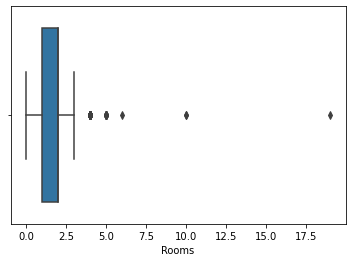

In [47]:
sns.boxplot(X_train['Rooms'])

Хоть по статистике и получается, что 4 и более комнат являются выбросами, но после просмотра данных по этим квартирам становится ясно, что 4 комнаты, это просто большие квартиры, а выбросы это  5 и более комнат.
По этому обработаем выбросы, заменив на ближайшее нормальное значение, и создадим доп признак для выделения изменения.  

In [48]:
X_train["Rooms_outlier"] = 0
X_train.loc[(X_train["Rooms"] >= 5), "Rooms_outlier"] = 1
X_train.loc[(X_train["Rooms"] >= 5), "Rooms"] = 4


#### Square

In [49]:
X_train["Square"].describe()

count    7000.000000
mean       56.349125
std        21.555962
min         1.988943
25%        41.784348
50%        52.413246
75%        65.981638
max       641.065186
Name: Square, dtype: float64

<AxesSubplot:xlabel='Square', ylabel='Density'>

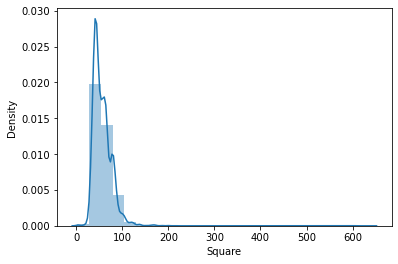

In [50]:
sns.distplot(X_train["Square"] , bins=25)

#### KitchenSquare

Очень странное распределение площади кухни, 0 и 1 метр. Однако таких значений очень много...

In [51]:
X_train["KitchenSquare_nan"] = 0
X_train.loc[X_train["KitchenSquare"].isnull(), "KitchenSquare_nan"] = 1
X_train.loc[X_train["KitchenSquare"].isnull(), "KitchenSquare"] = X_train["KitchenSquare"].median()

#### LifeSquare

<AxesSubplot:xlabel='LifeSquare', ylabel='Density'>

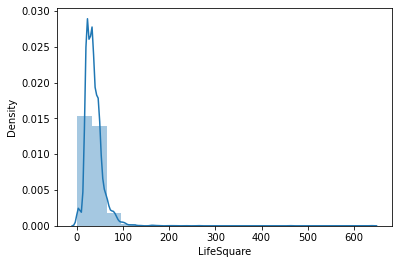

In [52]:
sns.distplot(X_train["LifeSquare"]  , bins=20)

Заполняя Нан значения средним или медианой по признаку, получается большой перекос, т.к. пропущенных значений слишком много.  Мы можем расчитать средний коэффициент отношения жилой площади к общей площади, и используя его спрогнозировать пропущенные значения.

In [53]:
X_train["LifeSquare_nan"] = 0
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare_nan"] = 1

In [54]:
life_square_coef =  X_train["LifeSquare"].mean() / X_train["Square"].mean()
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare"] = X_train.loc[X_train["LifeSquare"].isnull(), "Square"] * life_square_coef

<AxesSubplot:xlabel='LifeSquare', ylabel='Density'>

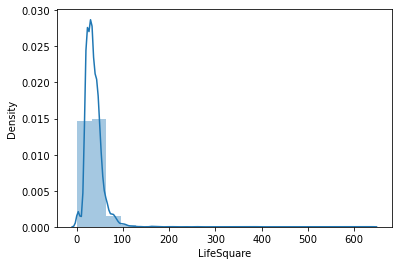

In [55]:
sns.distplot(X_train["LifeSquare"]  , bins=20)

График даже слегка подровнялся.

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 223 to 12518
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Rooms              7000 non-null   float32 
 1   Square             7000 non-null   float32 
 2   LifeSquare         7000 non-null   float32 
 3   KitchenSquare      7000 non-null   float32 
 4   Floor              7000 non-null   int8    
 5   HouseFloor         7000 non-null   float32 
 6   HouseYear          7000 non-null   int32   
 7   Ecology_1          7000 non-null   float32 
 8   Ecology_2          7000 non-null   category
 9   Ecology_3          7000 non-null   category
 10  Social_1           7000 non-null   int8    
 11  Social_2           7000 non-null   int16   
 12  Social_3           7000 non-null   int16   
 13  Healthcare_1       3622 non-null   float32 
 14  Helthcare_2        7000 non-null   int8    
 15  Shops_1            7000 non-null   int8    
 16  Sho

Исходя из графиков жилье явно делится на 3 кластера.

#### Floor

Как правило первый и последний этажи стоят дешевле, можно это пометить.


In [57]:
bad_floor = (X_train["Floor"] == 1) | (X_train["Floor"] == X_train["HouseFloor"])
X_train["Bad_floor"] = 0
X_train.loc[bad_floor, "Bad_floor"] = 1

In [58]:
X_train["Floor"].value_counts()

4     664
5     635
3     612
6     565
7     510
8     451
2     429
9     408
10    399
11    322
12    313
13    287
14    242
16    201
15    200
17    169
1     163
18    136
19     75
21     42
20     41
22     36
24     35
25     30
26     16
23     14
27      3
28      1
33      1
Name: Floor, dtype: int64

<AxesSubplot:xlabel='Floor', ylabel='Density'>

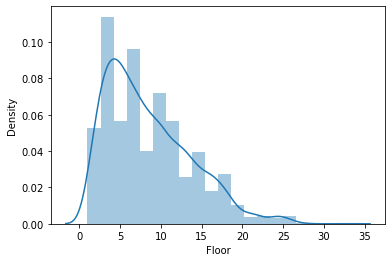

In [59]:
sns.distplot(X_train["Floor"]  , bins=20)

#### HouseFloor	

<AxesSubplot:xlabel='HouseFloor'>

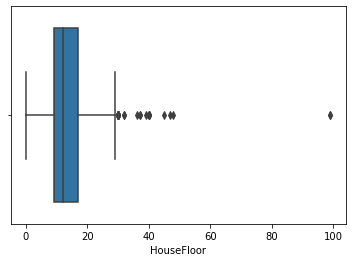

In [60]:
sns.boxplot(X_train["HouseFloor"])

Пометим высотки

In [61]:
X_train["HR_building"] = 0
X_train.loc[X_train["HouseFloor"] > 20, "HR_building"] = 1

In [62]:
X_train.loc[X_train["HouseFloor"] == 0].head(5) # 0 этажей явно ошибка

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,KitchenSquare_nan,LifeSquare_nan,Bad_floor,HR_building
Id,,,,,,,,,,,,,,,,,,,,,
770,0.0,49.483501,31.907494,0.0,16,0.0,2015,0.118537,B,B,...,1,1183.0,1,0,B,0,0,1,0,0
4579,2.0,48.148067,31.046391,0.0,6,0.0,1977,0.236108,B,B,...,27,NaN,3,10,B,0,0,1,0,0
5383,3.0,98.994911,63.832981,0.0,3,0.0,1977,0.041125,B,B,...,5,NaN,1,10,B,0,0,1,0,0
10414,1.0,46.416927,29.930134,0.0,8,0.0,1977,0.072158,B,B,...,1,NaN,0,0,A,0,0,1,0,0
9194,1.0,51.018288,22.370991,0.0,4,0.0,2016,0.017647,B,B,...,0,NaN,0,0,B,0,0,0,0,0


In [63]:
X_train["HouseFloor_outlier"] = 0
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor"] = X_train.loc[X_train["HouseFloor"] == 0, "Floor"]

#### HouseYear

In [64]:
from datetime import datetime
x = datetime.now()
X_train.loc[X_train["HouseYear"] > x.year, "HouseYear"] = X_train["HouseYear"].median()
X_train["HouseYear"] = x.year - X_train["HouseYear"]
X_train["HouseYear"].value_counts()

44     1846
5       226
6       216
4       211
7       145
       ... 
81        1
89        1
93        1
107       1
111       1
Name: HouseYear, Length: 95, dtype: int64

<AxesSubplot:>

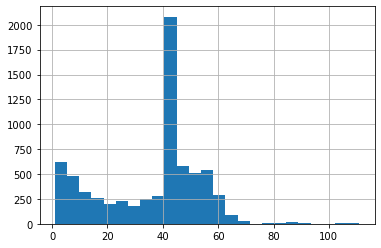

In [65]:
X_train["HouseYear"].hist(bins=25)

Было бы логично раскидать по категориям относительно года постройки.

In [66]:

X_train['New_house'] = 0
X_train.loc[X_train['HouseYear'] <= 5, 'New_house'] = 1  


#### Healthcare_1 

Слишком много пропусков, выкидываем.

In [67]:
X_train = X_train.drop('Healthcare_1', axis=1)

In [68]:
X_train['Ecology_2'] = (X_train['Ecology_2'] == 'A').astype(int)
X_train['Ecology_3'] = (X_train['Ecology_3'] == 'A').astype(int)
X_train['Shops_2'] = (X_train['Shops_2'] == 'A').astype(int)

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 223 to 12518
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               7000 non-null   float32
 1   Square              7000 non-null   float32
 2   LifeSquare          7000 non-null   float32
 3   KitchenSquare       7000 non-null   float32
 4   Floor               7000 non-null   int8   
 5   HouseFloor          7000 non-null   float32
 6   HouseYear           7000 non-null   int32  
 7   Ecology_1           7000 non-null   float32
 8   Ecology_2           7000 non-null   int32  
 9   Ecology_3           7000 non-null   int32  
 10  Social_1            7000 non-null   int8   
 11  Social_2            7000 non-null   int16  
 12  Social_3            7000 non-null   int16  
 13  Helthcare_2         7000 non-null   int8   
 14  Shops_1             7000 non-null   int8   
 15  Shops_2             7000 non-null   int32  
 16  Roo

Нужно сделать функцию которая очищает тестовые данные, используя статистики тренеровочного датасета.

In [70]:
#min_max = max_square, min_square, max_square_k, min_square_k, max_square_l, min_square_l
medians = X_train["Square"].median(), X_train["KitchenSquare"].median(), X_train["LifeSquare"].median(), X_train["HouseYear"].median()

In [71]:
def x_test_prepare(X_test_prepare, medians):
    #max_square, min_square, max_square_k, min_square_k, max_square_l, min_square_l = min_max
    square, kitchenSquare, lifeSquare, houseyear = medians
    
    X_test_prepare = X_test_prepare.set_index('Id')
    X_test_prepare = X_test_prepare.drop('DistrictId', axis = 1)
    X_test_prepare = X_test_prepare.drop('Healthcare_1', axis=1)
    X_test_prepare["Rooms_outlier"] = 0
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 6), "Rooms_outlier"] = 1
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 6), "Rooms"] = 4
    
    #X_test_prepare["Square_outlier"] = 0
    #outlier_square = (X_test_prepare["Square"] > max_square) | (X_test_prepare["Square"] < min_square)
    #X_test_prepare.loc[outlier_square, "Square_outlier"] = 1
    #X_test_prepare.loc[outlier_square, "Square"] = square
    
    
    #X_test_prepare["KitchenSquare_outlier"] = 0
    #outlier_square_k = (X_test_prepare["KitchenSquare"] > max_square_k) | (X_test_prepare["KitchenSquare"] < min_square_k)
    #X_test_prepare.loc[outlier_square_k, "KitchenSquare_outlier"] = 1
    #X_test_prepare.loc[X_test_prepare["KitchenSquare"] > max_square_k, "KitchenSquare"] = max_square_k
    #X_test_prepare.loc[X_test_prepare["KitchenSquare"] < min_square_k, "KitchenSquare"] = min_square_k
    
    X_test_prepare["KitchenSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["KitchenSquare"].isnull(), "KitchenSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["KitchenSquare"].isnull(), "KitchenSquare"] = kitchenSquare
    
    #X_test_prepare["LifeSquare_outlier"] = 0
    #outlier_square_l = (X_test_prepare["LifeSquare"] > max_square_l) | (X_test_prepare["LifeSquare"] < min_square_l)
    #X_test_prepare.loc[outlier_square_l, "LifeSquare_outlier"] = 1
    #X_test_prepare.loc[outlier_square_l, "LifeSquare"] = lifeSquare
    
    X_test_prepare["LifeSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare"] = X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "Square"] * life_square_coef
    
    X_test_bad_floor = (X_test_prepare["Floor"] == 1) | (X_test_prepare["Floor"] == X_test_prepare["HouseFloor"])
    X_test_prepare["Bad_floor"] = 0
    X_test_prepare.loc[X_test_bad_floor, "Bad_floor"] = 1
    
    X_test_prepare["HR_building"] = 0
    X_test_prepare.loc[X_test_prepare["HouseFloor"] > 20, "HR_building"] = 1
    
    X_test_prepare["HouseFloor_outlier"] = 0
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor"] = X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "Floor"]
    
    x = datetime.now()
    X_test_prepare.loc[X_test_prepare["HouseYear"] > x.year, "HouseYear"] = houseyear
    X_test_prepare["HouseYear"] = x.year - X_test_prepare["HouseYear"]
    
    X_test_prepare['New_house'] = 0
    X_test_prepare.loc[X_test_prepare['HouseYear'] <= 5, 'New_house'] = 1  
    X_test_prepare['Ecology_2'] = (X_test_prepare['Ecology_2'] == 'A').astype(int)
    X_test_prepare['Ecology_3'] = (X_test_prepare['Ecology_3'] == 'A').astype(int)
    X_test_prepare['Shops_2'] = (X_test_prepare['Shops_2'] == 'A').astype(int) 
   
    return X_test_prepare

In [72]:
X_valid = x_test_prepare(X_valid, medians)

In [73]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 3614 to 4504
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               3000 non-null   float32
 1   Square              3000 non-null   float32
 2   LifeSquare          3000 non-null   float32
 3   KitchenSquare       3000 non-null   float32
 4   Floor               3000 non-null   int8   
 5   HouseFloor          3000 non-null   float32
 6   HouseYear           3000 non-null   int32  
 7   Ecology_1           3000 non-null   float32
 8   Ecology_2           3000 non-null   int32  
 9   Ecology_3           3000 non-null   int32  
 10  Social_1            3000 non-null   int8   
 11  Social_2            3000 non-null   int16  
 12  Social_3            3000 non-null   int16  
 13  Helthcare_2         3000 non-null   int8   
 14  Shops_1             3000 non-null   int8   
 15  Shops_2             3000 non-null   int32  
 16  Roo

In [74]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 223 to 12518
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               7000 non-null   float32
 1   Square              7000 non-null   float32
 2   LifeSquare          7000 non-null   float32
 3   KitchenSquare       7000 non-null   float32
 4   Floor               7000 non-null   int8   
 5   HouseFloor          7000 non-null   float32
 6   HouseYear           7000 non-null   int32  
 7   Ecology_1           7000 non-null   float32
 8   Ecology_2           7000 non-null   int32  
 9   Ecology_3           7000 non-null   int32  
 10  Social_1            7000 non-null   int8   
 11  Social_2            7000 non-null   int16  
 12  Social_3            7000 non-null   int16  
 13  Helthcare_2         7000 non-null   int8   
 14  Shops_1             7000 non-null   int8   
 15  Shops_2             7000 non-null   int32  
 16  Roo

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [76]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}
rfr = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [77]:
model = RandomForestRegressor(max_depth=9, max_features=8, n_estimators=150, random_state=47)

In [78]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features=8, n_estimators=150,
                      random_state=47)

In [79]:
y_pred = model.predict(X_valid)

In [82]:
r2_score(y_valid, y_pred)


0.7151909413167421

In [ ]:
0.7151909413167421

Без обработки выбросов  и  стандартизации.